# Data Aknoweldgements

This kernel uses the dataset [Chest X-Ray Images with Pneumothorax Masks](https://www.kaggle.com/vbookshelf/pneumothorax-chest-xray-images-and-masks) from [Kaggle](https://www.kaggle.com)

In [0]:
import fastai
from fastai.vision import *

In [0]:
!mkdir .kaggle
!mv kaggle.json .kaggle
!chmod 600 /content/.kaggle/kaggle.json
! mkdir ~/.kaggle/
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In [0]:
fastai.__version__

'1.0.60'

In [0]:
#use this command to see GPU activity while doing Deep Learning tasks, for this command 'nvidia-smi' and for above one to work, go to 'Runtime > change runtime type > Hardware Accelerator > GPU'
!nvidia-smi

In [0]:
!mkdir data

In [0]:
!kaggle datasets download -d vbookshelf/pneumothorax-chest-xray-images-and-masks -p data

100% 4.49G/4.50G [01:33<00:00, 10.3MB/s]
100% 4.50G/4.50G [01:33<00:00, 51.7MB/s]


In [0]:
%%time
# Unzip the zipfile into /content/data quietly
!unzip -o -q data/pneumothorax-chest-xray-images-and-masks.zip -d data

CPU times: user 406 ms, sys: 47.8 ms, total: 454 ms
Wall time: 1min 52s


In [0]:
# Count how many files got unzipped
!echo files in /content/data: `ls -R data | wc -l`

files in /content/data: 24107


In [0]:
path = Path('/content/data/siim-acr-pneumothorax/')
path_mask=path/'png_masks'

In [0]:
df_train = pd.read_csv(path/'stage_1_train_images.csv')
df_test = pd.read_csv(path/'stage_1_test_images.csv')

In [0]:
df_train.head(5)

,new_filename,ImageId,has_pneumo
0,0_train_0_.png,1.2.276.0.7230010.3.1.4.8323329.5597.151787518...,0
1,1_train_0_.png,1.2.276.0.7230010.3.1.4.8323329.12515.15178752...,0
2,2_train_1_.png,1.2.276.0.7230010.3.1.4.8323329.4904.151787518...,1
3,3_train_1_.png,1.2.276.0.7230010.3.1.4.8323329.32579.15178751...,1
4,4_train_1_.png,1.2.276.0.7230010.3.1.4.8323329.1314.151787516...,1


In [0]:
df_test.head(5)

,new_filename,ImageId,has_pneumo
0,0_test_1_.png,1.2.276.0.7230010.3.1.4.8323329.5797.151787519...,1
1,1_test_0_.png,1.2.276.0.7230010.3.1.4.8323329.5798.151787519...,0
2,2_test_0_.png,1.2.276.0.7230010.3.1.4.8323329.5799.151787519...,0
3,3_test_0_.png,1.2.276.0.7230010.3.1.4.8323329.580.1517875163...,0
4,4_test_0_.png,1.2.276.0.7230010.3.1.4.8323329.5800.151787519...,0


In [0]:
bs,size=32,256

In [0]:
data_gen=(src.label_from_func(lambda x: path_mask/Path(x).name)
      .transform(get_transforms(max_zoom=2.),size=size, tfm_y=True)
      .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

In [0]:
# Setting div=True in open_mask
class SegmentationLabelList(SegmentationLabelList):
    def open(self, fn): return open_mask(fn, div=True)
    
class SegmentationItemList(SegmentationItemList):
    _label_cls = SegmentationLabelList

# Setting transformations on masks to False on test set
def transform(self, tfms:Optional[Tuple[TfmList,TfmList]]=(None,None), **kwargs):
    if not tfms: tfms=(None,None)
    assert is_listy(tfms) and len(tfms) == 2
    self.train.transform(tfms[0], **kwargs)
    self.valid.transform(tfms[1], **kwargs)
    kwargs['tfm_y'] = False # Test data has no labels
    if self.test: self.test.transform(tfms[1], **kwargs)
    return self
fastai.data_block.ItemLists.transform = transform

In [0]:
# Create databunch
data = (SegmentationItemList.from_df(df=df_train, path=path/'png_images')
        .split_by_rand_pct(0.2)
        .label_from_func(lambda x : str(x).replace('images', 'masks'), classes=[0, 1])
        .add_test([path/'png_images'/x for x in df_test.new_filename], label=None)
        .transform(get_transforms(), size=size, tfm_y=True)
        .databunch(path=Path('.'), bs=bs)
        .normalize(imagenet_stats))

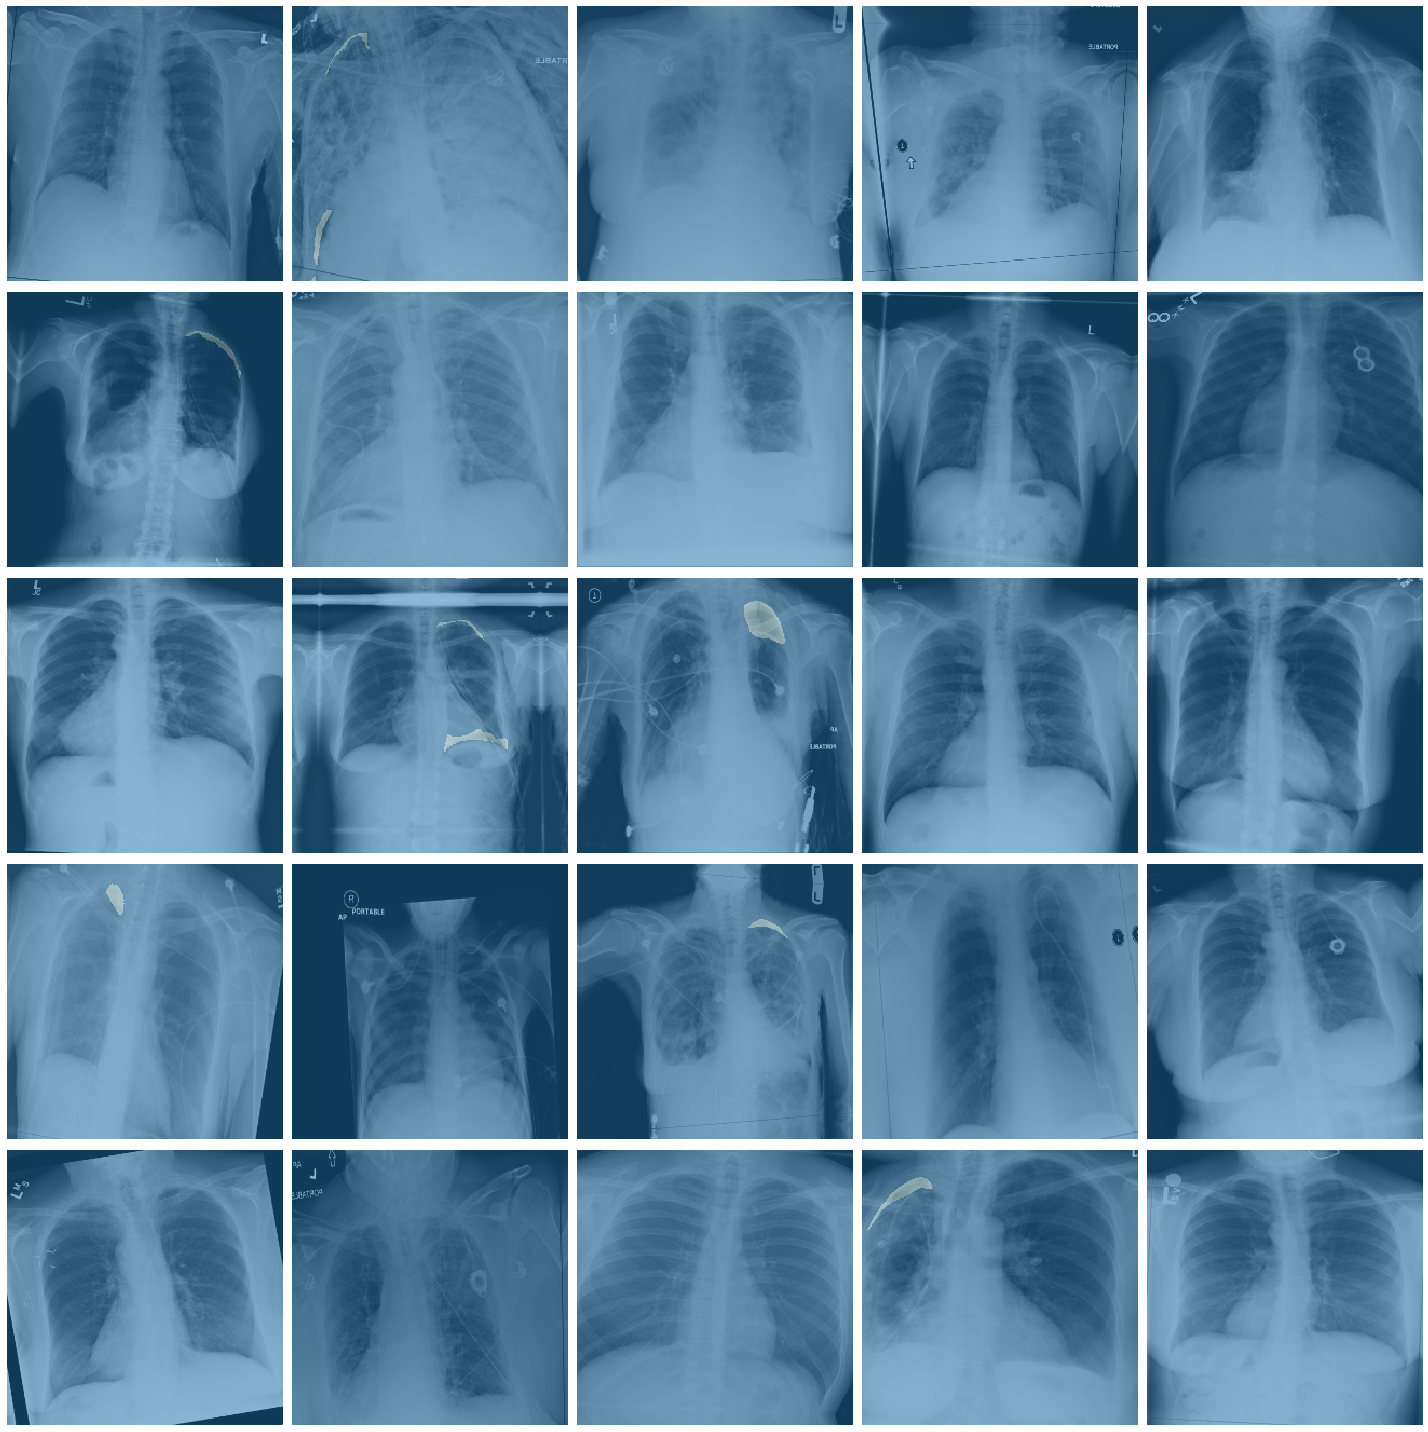

In [0]:
# Display some images with masks
data.show_batch()

In [0]:
# Create U-Net with a pretrained resnet34 as encoder
learn = unet_learner(data, models.resnet34, metrics=[dice])

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [0]:
# Fit one cycle of 6 epochs with max lr of 1e-3
learn.fit_one_cycle(6)

epoch,train_loss,valid_loss,dice,time
0,0.020615,0.016001,0.779859,09:17
1,0.022727,0.013916,0.779859,09:00
2,0.013897,0.011531,0.779859,08:27
3,0.012764,0.009804,0.766705,08:26
4,0.010408,0.009658,0.789247,08:31
5,0.009456,0.009193,0.787890,08:43


In [0]:
learn.save('pneumo-mid')

In [0]:
# Unfreeze the encoder (resnet34)
learn.unfreeze()

In [0]:
# Fit one cycle of 12 epochs
lr = 1e-3
learn.fit_one_cycle(12, slice(lr/30, lr))

epoch,train_loss,valid_loss,dice,time
0,0.009900,0.008997,0.764928,08:43
1,0.010142,0.008784,0.784585,08:41
2,0.010572,0.009466,0.786815,08:45
3,0.009716,0.009669,0.783628,08:38
4,0.009289,0.008902,0.783229,08:47
5,0.008512,0.008234,0.773714,09:03
6,0.008184,0.007914,0.778886,09:08
7,0.007787,0.007958,0.793447,09:04
8,0.006948,0.008194,0.799155,09:03
9,0.006338,0.008075,0.803266,09:07


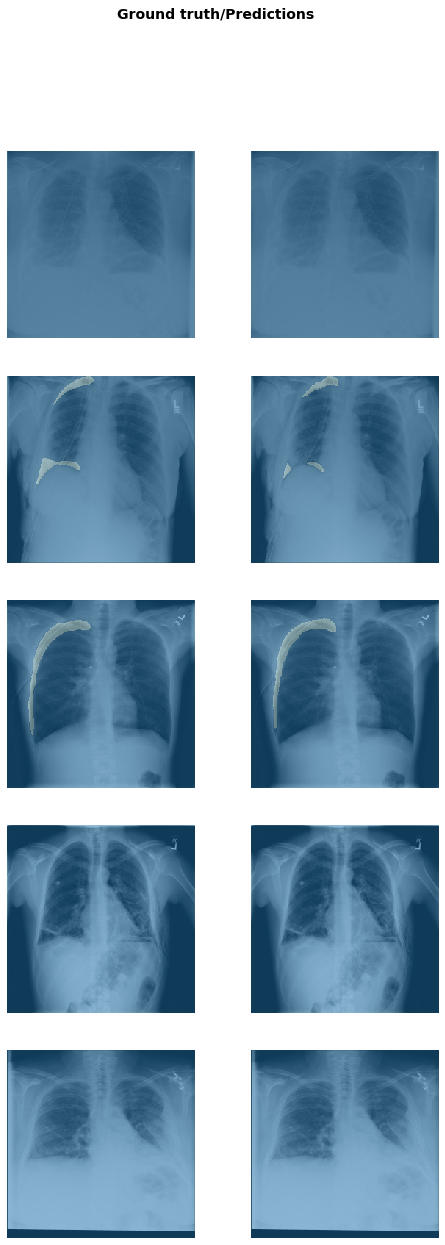

In [0]:
learn.show_results(10)

In [0]:
learn.export('final.pkl')